# Vehicle Detection

### Steps Involved

1. Data Exploration
2. Feature Engineering - Color histograms, spatial bins, HOG features
3. Classification - Build classifier using algo such as DT, SVM or GBM, hyper-parameter tuning
4. Sliding window for search
5. HOG sub-sample
6. Heatmaps to eliminate false positives
7. Use techniques such as averaging across frames to smoothen tracking
8. Build pipeline
9. Test on Video stream

## Data Exploration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage import color, exposure
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.svm import SVC
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


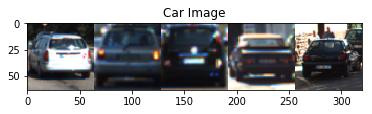

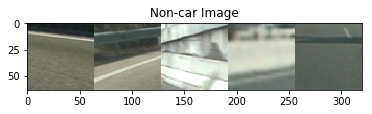

In [2]:
# # images are divided up into vehicles and non-vehicles

base_dir = "/home/pyimagesearch/CarND-Vehicle-Detection/training/"

cars_string = base_dir + 'vehicles/*/' + '*.png'
non_cars_string = base_dir + 'non-vehicles/*/' + '*.png'

cars = glob.glob(cars_string)
notcars = glob.glob(non_cars_string)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    example_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

data_info = data_look(cars, notcars)

print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:',
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_ind_list = range(car_ind, car_ind+5)
notcar_ind_list = range(notcar_ind, notcar_ind+5)

# Read in car / not-car images
car_images = np.hstack((mpimg.imread(cars[car_ind]) for car_ind in car_ind_list))
notcar_images = np.hstack((mpimg.imread(notcars[notcar_ind]) for notcar_ind in notcar_ind_list))


# Plot the examples
fig = plt.figure()
plt.imshow(car_images)
plt.title('Car Image')
fig = plt.figure()
plt.imshow(notcar_images)
plt.title('Non-car Image')
plt.show()

## Feature Engineering

In [3]:

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

def translate_image(img):
    
    rows,cols,channel = img.shape
    tx =  np.random.randint(-5, 5)
    ty =  np.random.randint(-5, 5)

    M = np.float32([[1,0,tx],[0,1,ty]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    #plt.figure()
    #plt.imshow(dst)
    return dst

def rotate_image(img, angle = 0):
    rows,cols,channel = img.shape
    theta = 15
    angle = np.random.randint(-theta, theta)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    #plt.figure()
    #plt.imshow(dst)
    return dst

## HOG Features

In [4]:

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, 
                     cspace='RGB', 
                     orient=9,
                     pix_per_cell=8, 
                     cell_per_block=2, 
                     hog_channel=0, 
                     nbins=32, 
                     bins_range=(0, 256), 
                     size=(32, 32),
                     need_hog_features = True,
                     need_spatial_features = True,
                     need_color_features = True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        original = mpimg.imread(file)
        
        # Augment Data
        rotated = rotate_image(original)
        translated = translate_image(original)
        flipped = cv2.flip(original, 1)
        
        for image in [original, rotated, translated, flipped]:
            # apply color conversion if other than 'RGB'
            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif cspace == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image)

            # HOG Features
            if need_hog_features == True:
                # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)
                else:
                    hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)

            # Spatial Features
            if need_spatial_features == True:
                spatial_features = bin_spatial(feature_image, size)

            # Color histogram Features
            if need_color_features == True:
                color_features = color_hist(feature_image, nbins, bins_range)

            # Append the new feature vector to the features list
            features.append(np.concatenate((hog_features, spatial_features, color_features)).ravel())       
            
    # Return list of feature vectors
    return features

In [5]:
# Extract features for single image

def extract_features_image(image, 
                     cspace='RGB', 
                     orient=9,
                     pix_per_cell=8, 
                     cell_per_block=2, 
                     hog_channel=0, 
                     nbins=32, 
                     bins_range=(0, 256), 
                     size=(32, 32),
                     need_hog_features = True,
                     need_spatial_features = True,
                     need_color_features = True):
    # Create a list to append feature vectors to
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    # HOG Features
    if need_hog_features == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Spatial Features
    if need_spatial_features == True:
        spatial_features = bin_spatial(feature_image, size)

    # Color histogram Features
    if need_color_features == True:
        color_features = color_hist(feature_image, nbins, bins_range)

    # Append the new feature vector to the features list
    features.append(np.concatenate((hog_features, spatial_features, color_features)).ravel())       
            
    # Return list of feature vectors
    return features

## Classification

In [6]:
### Tweak these parameters and see how the results change.
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
nbins=32
bins_range=(0, 256)
size=(32, 32)
need_hog_features = True
need_spatial_features = True
need_color_features = True

t=time.time()

car_features = extract_features(cars, 
                                cspace=colorspace, 
                                orient=orient,
                                pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel,
                                nbins=32, 
                                bins_range=(0, 256), 
                                size=(32,32),
                                need_hog_features=True,
                                need_spatial_features=True,
                                need_color_features=True)

notcar_features = extract_features(notcars,
                                   cspace=colorspace, 
                                   orient=orient,
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel,
                                   nbins=32,
                                   bins_range=(0,256), 
                                   size=(32,32),
                                   need_hog_features=True,
                                   need_spatial_features=True,
                                   need_color_features=True)
                                
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print("X_train shape =" + str(X_train.shape))
print("X_test shape =" + str(X_test.shape))

k_best = SelectKBest(f_classif, k=2000)
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)
    
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

#param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

#param_grid = {'C': [1e3, 5e3, 1e4],
#              'gamma': [0.0001, 0.0005, 0.001, 0.005], }
              
#clf = RandomizedSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, verbose=6)


clf = SVC(kernel='rbf', class_weight='balanced', C=1e3, gamma=1e-5)

# Check the training time for the SVC
t=time.time()
print("Starting training...")
clf.fit(X_train, y_train)
print("Done")
t2 = time.time()

/home/pyimagesearch/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


280.93 Seconds to extract HOG features...
X_train shape =(56832, 4932)
X_test shape =(14208, 4932)


MemoryError: 

In [67]:
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 20

print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)

73.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9778
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  0.
  0.  0.]
For these 20 labels:  [ 1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  1.  0.
  0.  0.]
0.06392 Seconds to predict 20 labels with SVC


In [68]:
clf

SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-05, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Sliding Window Search

cars_file = /home/pyimagesearch/CarND-Vehicle-Detection/test_images/test4.jpg


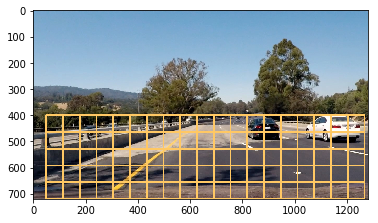

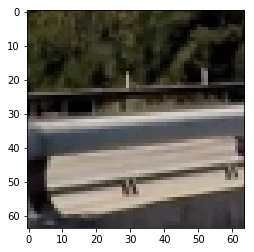

/home/pyimagesearch/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


prediction = [ 1.]


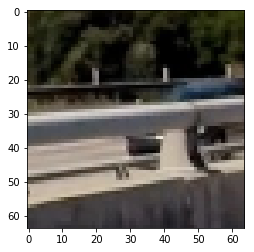

prediction = [ 1.]


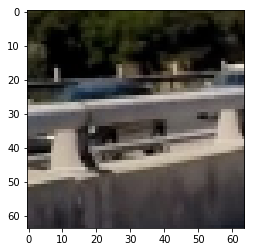

prediction = [ 1.]


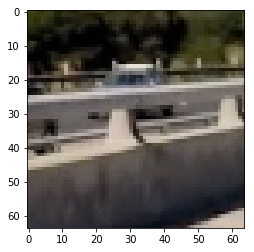

prediction = [ 1.]


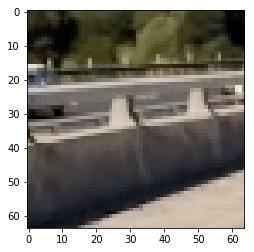

prediction = [ 1.]


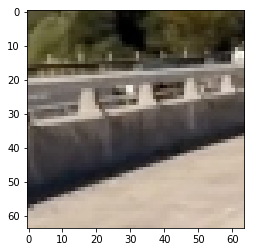

prediction = [ 1.]


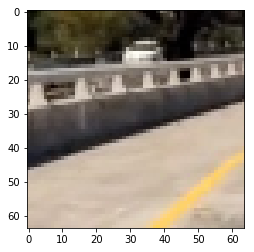

prediction = [ 1.]


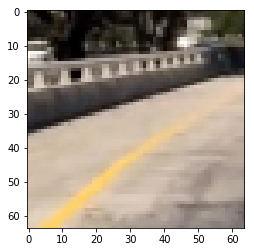

prediction = [ 1.]


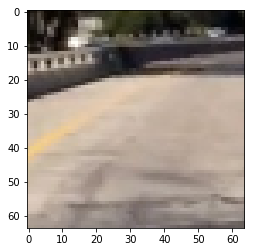

prediction = [ 1.]


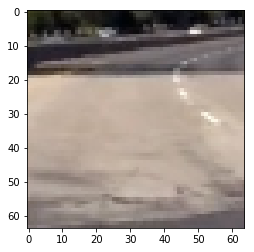

prediction = [ 1.]


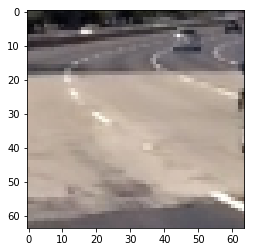

prediction = [ 1.]


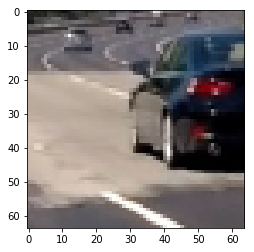

prediction = [ 1.]


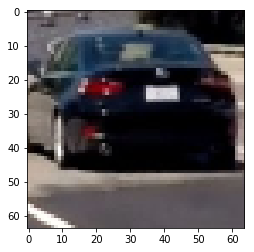

prediction = [ 1.]


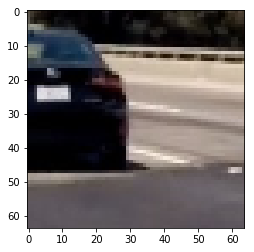

prediction = [ 1.]


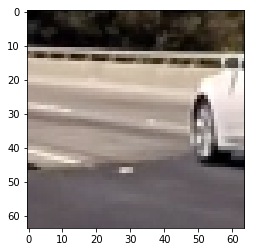

prediction = [ 1.]


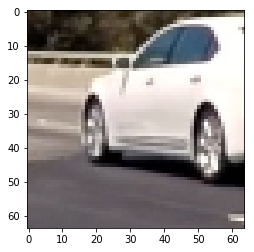

prediction = [ 1.]


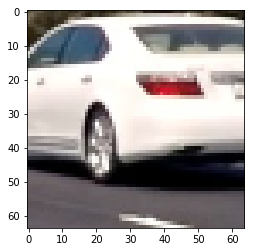

prediction = [ 1.]


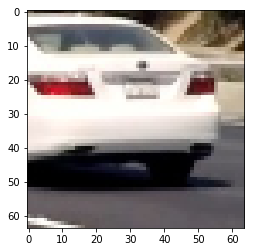

prediction = [ 1.]


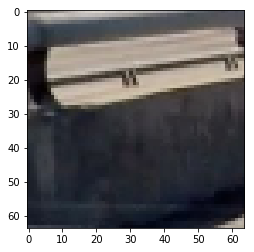

prediction = [ 1.]


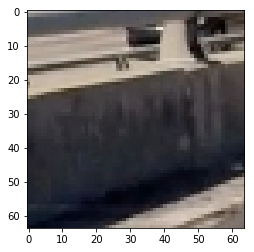

prediction = [ 1.]


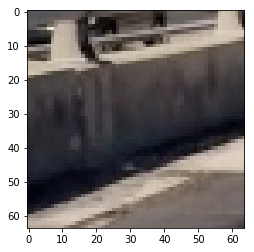

prediction = [ 1.]


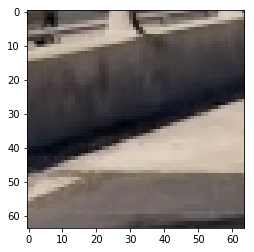

prediction = [ 1.]


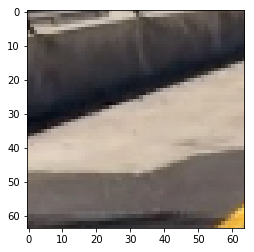

prediction = [ 1.]


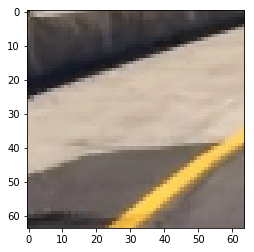

prediction = [ 1.]


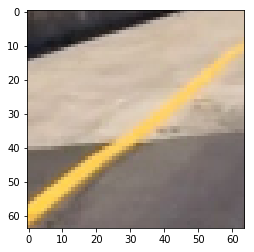

prediction = [ 1.]


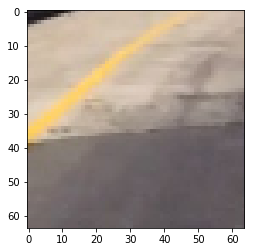

prediction = [ 1.]


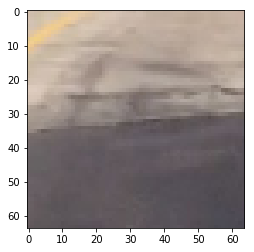

prediction = [ 1.]


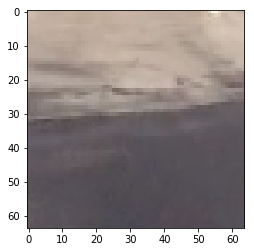

prediction = [ 1.]


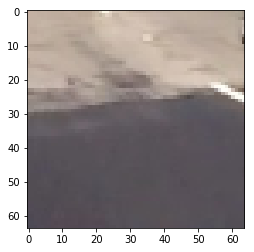

prediction = [ 1.]


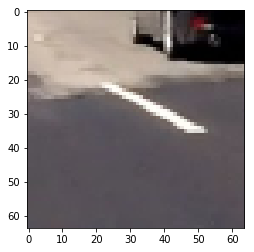

prediction = [ 1.]


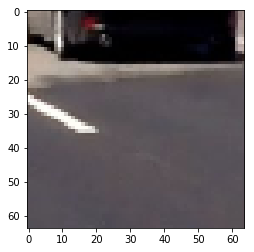

prediction = [ 1.]


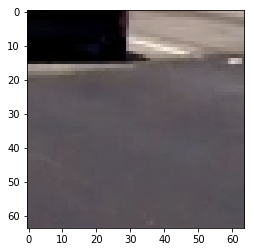

prediction = [ 1.]


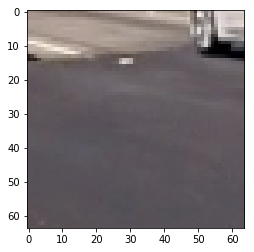

prediction = [ 1.]


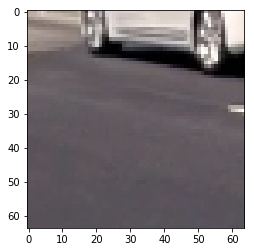

prediction = [ 1.]


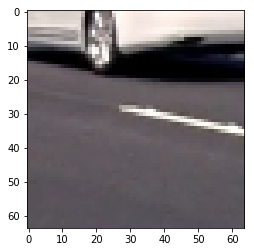

prediction = [ 1.]


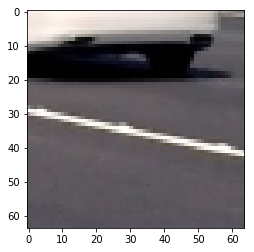

prediction = [ 1.]


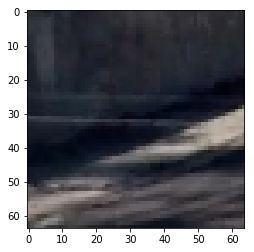

prediction = [ 1.]


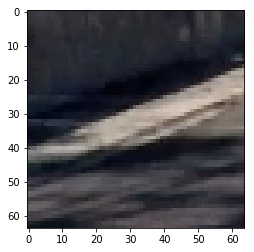

prediction = [ 1.]


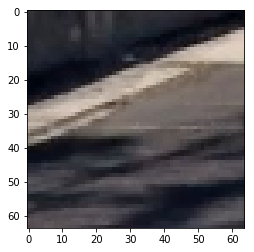

prediction = [ 1.]


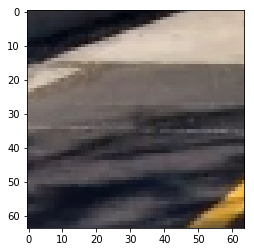

prediction = [ 1.]


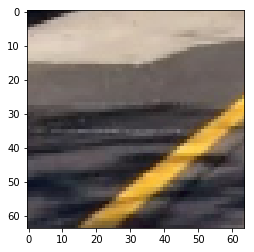

prediction = [ 1.]


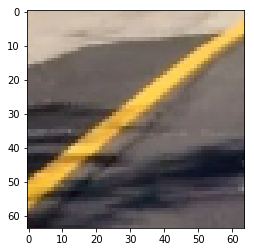

prediction = [ 1.]


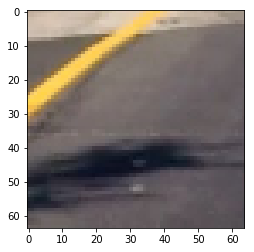

prediction = [ 1.]


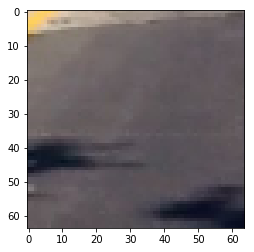

prediction = [ 1.]


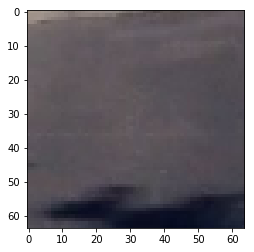

prediction = [ 1.]


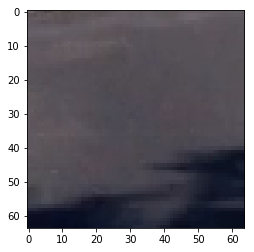

prediction = [ 1.]


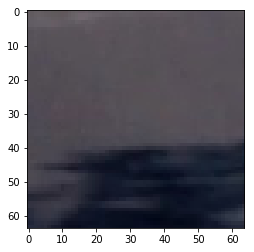

prediction = [ 1.]


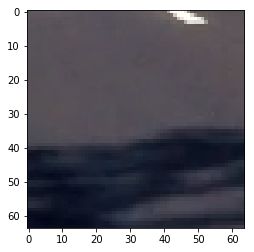

prediction = [ 1.]


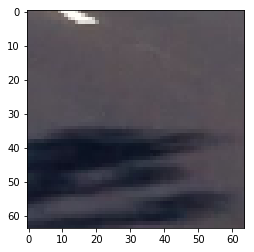

prediction = [ 1.]


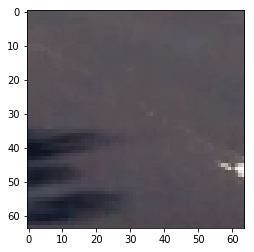

prediction = [ 1.]


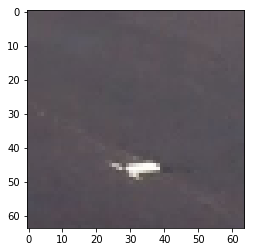

prediction = [ 1.]


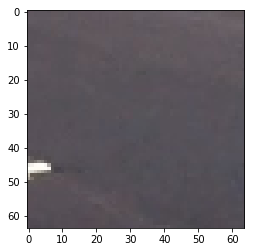

prediction = [ 1.]


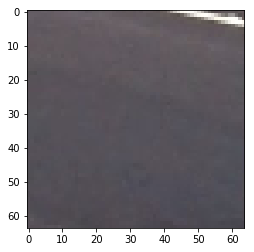

prediction = [ 1.]


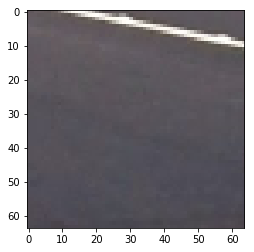

prediction = [ 1.]


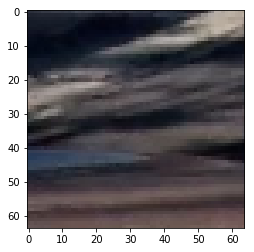

prediction = [ 1.]


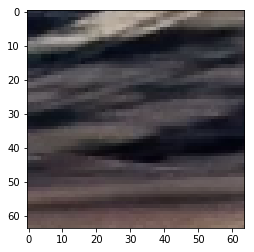

prediction = [ 1.]


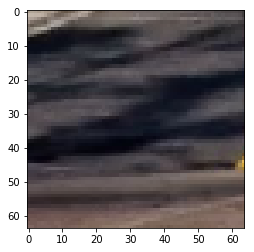

prediction = [ 1.]


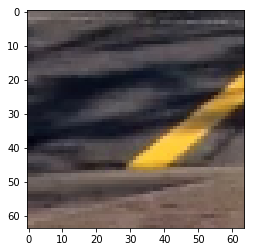

prediction = [ 1.]


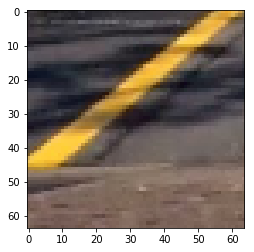

prediction = [ 1.]


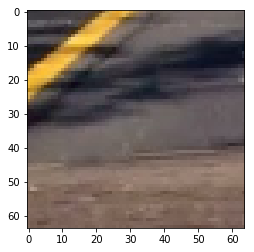

prediction = [ 1.]


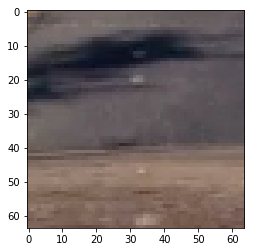

prediction = [ 1.]


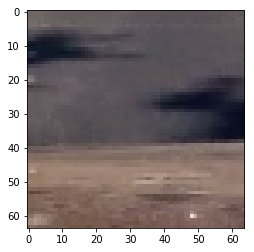

prediction = [ 1.]


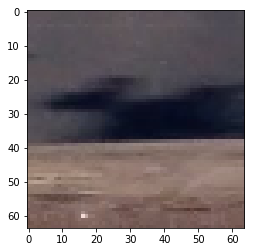

prediction = [ 1.]


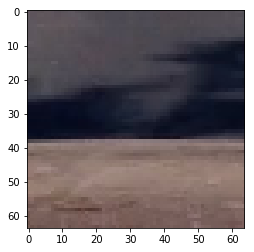

prediction = [ 1.]


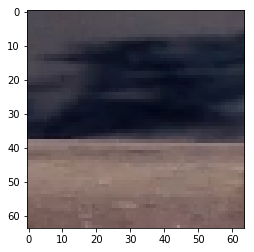

prediction = [ 1.]


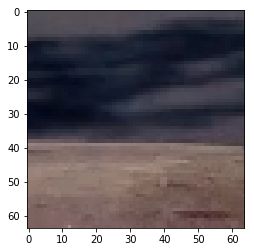

prediction = [ 1.]


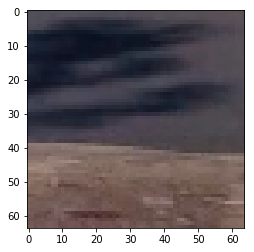

prediction = [ 1.]


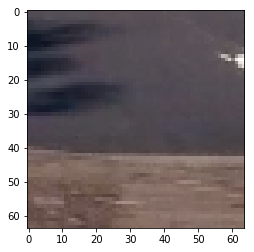

prediction = [ 1.]


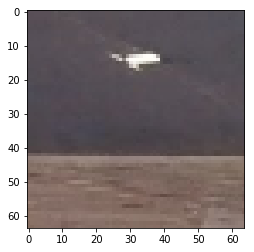

prediction = [ 1.]


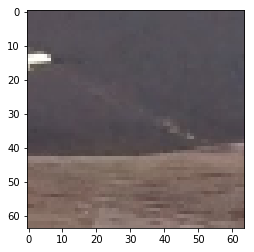

prediction = [ 1.]


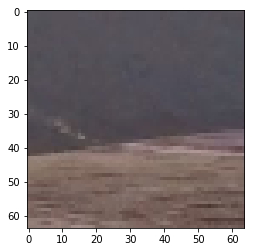

prediction = [ 1.]


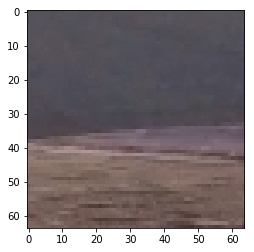

prediction = [ 1.]


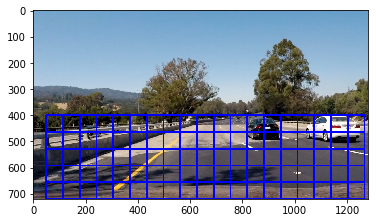

In [69]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        if (bbox[0][1]-bbox[0][0] != 0 and bbox[1][1]-bbox[1][0] != 0):
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):

    print("Image shape = " + str(img.shape))
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched

    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Compute the number of pixels per step in x/y
    nx_pixel_per_step = xy_window[0] * (1 - xy_overlap[0])
    ny_pixel_per_step = xy_window[1] * (1 - xy_overlap[1])

    # Compute the number of windows in x/y

    window_count_x = (int(img.shape[1]/int(xy_window[1]*xy_overlap[1])) - 1)
    window_count_y = (int(img.shape[0]/int(xy_window[0]*xy_overlap[0])) - 1)

    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for win_y in range(window_count_y):
        for win_x in range(window_count_x):
            startx = int(win_x * nx_pixel_per_step + x_start_stop[0])
            endx = int(startx + xy_window[0])

            starty = int(win_y * ny_pixel_per_step + y_start_stop[0])
            endy = int(starty + xy_window[1])

            window_list.append(((startx, starty), (endx, endy)))

    # Return the list of windows
    return window_list

# Sliding window 2
def slide_window2(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    X_my_test = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        plt.imshow(test_img)
        plt.show()
        #4) Extract features for that window using single_img_features()
        features = extract_features_image(test_img,
                                   cspace=colorspace, 
                                   orient=orient,
                                   pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel,
                                   nbins=32, 
                                   bins_range=(0,256), 
                                   size=(32,32),
                                   need_hog_features=hog_feat,
                                   need_spatial_features=spatial_feat,
                                   need_color_features=hist_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        best_test_features = k_best.transform(test_features)
        #6) Predict using your classifier
        prediction = clf.predict(best_test_features)
        print("prediction = " + str(prediction))
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

cars_file = '/home/pyimagesearch/CarND-Vehicle-Detection/' + 'test_images/' + 'test4.jpg'
print("cars_file = " + str(cars_file))

test_image = mpimg.imread(cars_file)
draw_image = np.copy(test_image)

windows = slide_window2(test_image, x_start_stop=[50, None], y_start_stop=[400, None],
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_image, windows, color=(255, 200, 100), thick=6)
plt.imshow(window_img)
plt.show()

# Parameters for HOG, spatial and color histogram features

color_space = 'YUV'
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

x_start_stop = [50, None]
y_start_stop = [400, None] # Min and max in y to search in slide_window()


hot_windows = search_windows(test_image, windows, clf, X_scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

plt.imshow(window_img)
plt.show()

## HOG Sub-sampling

## Heat Maps

## Avearaging